In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import bin_utils as ut
import bin_model_env as me

In [4]:
fnames=[
    # First worm
    'Data/traj12-11-2020_19-04-41.pkl', #none
    'Data/traj12-11-2020_19-14-38.pkl', #none
    'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
    # 'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others
    # Second worm
    'Data/traj12-11-2020_19-55-19.pkl', #none
    'Data/traj12-11-2020_20-05-11.pkl', #none
    'Data/traj12-11-2020_20-15-17.pkl', #none
    'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430
]

xlims = [1e6,1e6,800,1e6,1e6,1e6,1430]

traj_df = ut.make_df(fnames,xlimit=xlims,time_steps=10)
dist_dict = ut.make_dist_dict(traj_df)

In [5]:
class Q_Agent_Base():
    # Following pseudocode from pp131. 
    # Assumes epsilon greedy.
    def __init__(self,
                env,
                gamma=0.98,
                epsilon=0.05,
                q_checkpoint = None,
                ):
        
        # Set hyperparameters and env
        self.gamma = gamma
        self.epsilon = epsilon
        self.obs_n = env.observation_space.n
        self.act_n = env.action_space.n
        
        # Initialize Q table with optimistic starts
        if q_checkpoint is None:
            self.Qtab = np.random.normal(2,.5,size=(self.obs_n, self.act_n))
        else:
            self.Qtab = q_checkpoint
        
        # Initialize other things
        self.eps = 0
        self.steps = 0 # For current episode, not sure if this will be useful
        self.tot_steps = 0
    
    def update(self, obs, action, next_obs, reward):
        raise NotImplementedError
        
    def act(self, obs=None):        
        if obs is None or np.random.random() < self.epsilon:
            # Chooses random action if no observation (first step) OR if epsilon condition passes
            return np.random.choice(self.act_n)
        else:
            # Choose a greedy action
            return np.argmax(self.Qtab[obs,:])          
        
    def eval_act(self, obs):
        if obs is None:
            return np.random.choice(self.act_n)
        else:
            # Choose a greedy action
            return np.argmax(self.Qtab[obs,:])    

In [6]:
class Q_Av_Agent(Q_Agent_Base):
    # Following pseudocode from pp131. 
    # Except using averaging instead of steps, because all these data should be the same.
    def __init__(self,
                env,
                gamma=0.98,
                epsilon=0.05,
                q_checkpoint = None,
                q_counts_checkpoint = None,
                ):
        
        super().__init__(env,
                         gamma=gamma,
                         epsilon=epsilon,
                         q_checkpoint=q_checkpoint)
        
        # Initialize counts matrix
        if q_counts_checkpoint is not None:
            self.Qtab_counts = q_counts_checkpoint
        else:
            self.Qtab_counts = np.zeros((self.obs_n, self.act_n))
    
    def update(self, obs, action, next_obs, reward):
        self.Qtab_counts[obs,action] += 1
        self.Qtab[obs,action] = self.Qtab[obs,action] + \
            (1/self.Qtab_counts[obs,action])*(reward + self.gamma*np.max(self.Qtab[next_obs,:]) - self.Qtab[obs,action])

class Q_Alpha_Agent(Q_Agent_Base):
    # Following pseudocode from pp131. 
    def __init__(self,
                env,
                gamma=0.98,
                epsilon=0.05,
                alpha=0.005,
                q_checkpoint = None,
                q_counts_checkpoint = None,
                ):
        
        super().__init__(env,
                         gamma=gamma,
                         epsilon=epsilon,
                         q_checkpoint=q_checkpoint)
        
        self.alpha = alpha
    
    def update(self, obs, action, next_obs, reward):
        self.Qtab[obs,action] = self.Qtab[obs,action] + \
            self.alpha*(reward + self.gamma*np.max(self.Qtab[next_obs,:]) - self.Qtab[obs,action])

In [7]:
def learner(agent, env,
            episodes = 50000,
            steps_per_ep = 1000,
            eps_per_eval = 1000,
           ):
    # Runs an evaluation episode every so often. Returns average rewards per step for these.
    # Returns average rewards for each episode.
    # Also returns agent.
    
    rewards = np.zeros(episodes)
    eval_rewards = np.zeros((episodes//eps_per_eval)+1)
    
    for ep in range(episodes):
        obs = env.reset()
        reward_vec = np.zeros(steps_per_ep)
        
        for step in range(steps_per_ep):
            action = agent.act(obs)
            next_obs, reward_vec[step], done, info = env.step(action)
            agent.update(obs, action, next_obs, reward_vec[step])
            obs = next_obs
        
        rewards[ep] = np.mean(reward_vec)
        
        # Evaluation episodes
        if ep%eps_per_eval==0 or ep==episodes-1:
            if ep%eps_per_eval==0:
                eval_reward_ind = ep//eps_per_eval
            else:
                eval_reward_ind = -1
            obs = env.reset()
            eval_reward_vec = np.zeros(steps_per_ep)
            
            for step in range(steps_per_ep):
                action = agent.eval_act(obs)
                obs, eval_reward_vec[step], done, info = env.step(action)
                
            eval_rewards[eval_reward_ind] = np.mean(eval_reward_vec)
            print(f'Eval {eval_reward_ind}: average {eval_rewards[eval_reward_ind]}')
    
    return agent, rewards, eval_rewards

In [8]:
toy_worm = me.FakeWorm(dist_dict)
alph_mouse = Q_Alpha_Agent(toy_worm)

In [ ]:
alph_mouse_learned, rewards, eval_rewards = learner(alph_mouse, toy_worm,
                                                   episodes=20000,
                                                   steps_per_ep=1000,
                                                   eps_per_eval=1000,)

Eval 0: average 7.473295884121925
Eval 1: average 8.680504727087982
Eval 2: average 9.902857021681001
Eval 3: average 9.117078330027534
Eval 4: average 9.239175012512518
Eval 5: average 9.112388277393254
Eval 6: average 9.562869235043227
Eval 7: average 10.087192463456365
Eval 8: average 9.430832609993747
Eval 9: average 9.073488318935732


# Hparams

gamma=0.98,
epsilon=0.05,
alpha=0.005,

episodes = 50000,
steps_per_ep = 1000,
eps_per_eval = 1000,

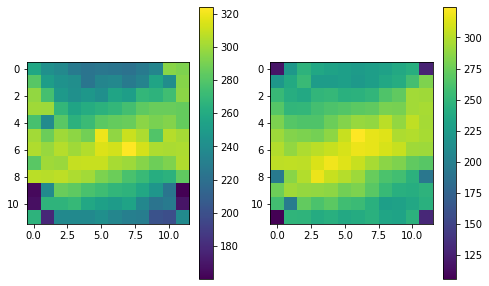

In [16]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((8,5))
for i in range(2):
    im = ax[i].imshow(alph_mouse_learned.Qtab[:,i].reshape(12,12))
    fig.colorbar(im,ax=ax[i])

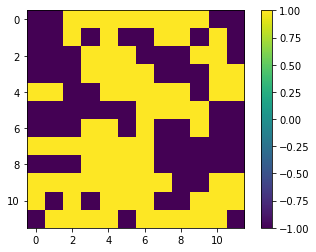

In [17]:
plt.imshow(np.sign(alph_mouse_learned.Qtab[:,1].reshape(12,12)-alph_mouse_learned.Qtab[:,0].reshape(12,12)))
plt.colorbar()

# Testing binned obs version (rewards unchanged)